remember that we will use optuna to use many algos inone go and find best from it BP170

# do 1st train test split and then do all this below 

## amenities

### method 1 :kmeans 

note : this method we can apply after train test split

In [233]:
# Combine values from columns that start with 'AM'
df['amenities'] = [list(values) for values in zip(*[df[col] for col in df.columns if col.startswith('am_')])]

In [234]:
df['amenities'] = df['amenities'].apply(lambda x: ', '.join(filter(pd.notna, x)))

In [235]:
df['amenities'].head()

0                                                                                                                                                                                                                                                                                                             club house, cafeteria/food court, bar/lounge, jogging and strolling track, outdoor tennis courts, barbeque pit, power back up, swimming pool, lift, security, park, reserved parking, service/goods lift, visitor parking, maintenance staff, bank & atm, banquet hall, gymnasium, indoor games room, aerobics room, laundry service, piped gas, rain water harvesting, water storage, indoor squash & badminton courts, arts & craft studio, multipurpose courts, meditation area, fingerprint access, premium branded fittings, waste disposal, conference room, mini cinema theatre, health club with steam / jaccuzi, located in the heart of city, large clubhouse, 3 tier security system, large open space, grand e

In [236]:
df['amenities'].isna().sum()

0

In [237]:
empty_string_count = (df['amenities'] == '').sum()
empty_string_count

5196

`observation`
- some rows in the amenities column are empty string (''), they are not considered NaN values.

In [238]:
import numpy as np
df['amenities'] = df['amenities'].replace('', np.nan)

In [239]:
df['amenities'].isna().sum()

5196

In [240]:
df['amenities'] = df['amenities'].fillna('unknown')

In [241]:
# Split the 'amenities' column into individual values, flatten the list, and find unique values
unique_amenities = set(floor.strip() for floors in df['amenities'] for floor in floors.split(','))

# Convert to a sorted list for better readability
unique_amenities = sorted(unique_amenities)

# Display the result
print(len(unique_amenities))

132


In [242]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split flooring combinations into individual materials
df['amenities_split'] = df['amenities'].str.split(', ')

# Use MultiLabelBinarizer to create binary features
mlb = MultiLabelBinarizer()
amenities_matrix = mlb.fit_transform(df['amenities_split'])

# Create a DataFrame for encoded flooring data
amenities_encoded = pd.DataFrame(amenities_matrix, columns=mlb.classes_)


In [243]:
amenities_encoded.head()

,3 tier security system,ac in each room,activity deck4,aerobics room,aesthetically designed landscape garden,air conditioned,all wooden flooring,art center,arts & craft studio,badminton court,...,volleyball court,waste disposal,waste water recycling,water front,water storage,water treatment plant,wheelchair accessibility,whiteboard,wine cellar,wrap around balcony
0,1,0,0,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
1,1,0,1,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


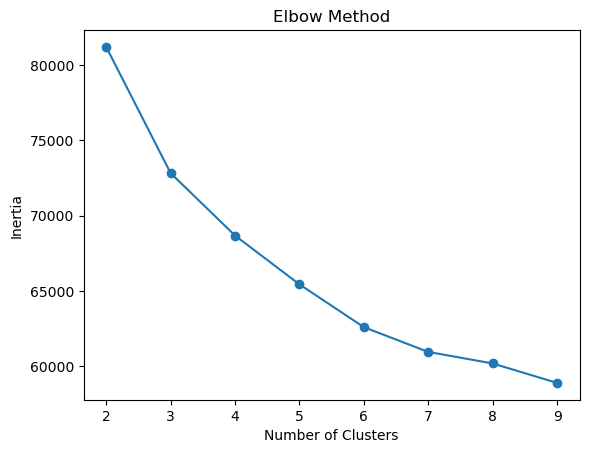

In [244]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Find the optimal number of clusters (Elbow Method)
inertia = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(amenities_encoded)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Use the chosen number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df['amenities_cluster'] = kmeans.fit_predict(amenities_encoded)


In [245]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(amenities_encoded, df['amenities_cluster'])
print("Silhouette Score for 5 clusters:", silhouette_avg)

Silhouette Score for 5 clusters: 0.41231547297131194


In [246]:
df['amenities_cluster'].value_counts()

amenities_cluster
1    5541
3    2429
0    2304
2    1055
4     674
Name: count, dtype: int64

`observation` 
- silhouette score is above 0.5, means clustering is generally well-formed. If it's lower (e.g., below 0.3), we might reconsider the number of clusters and 0.4 to 0.5: Moderate clustering performance — some overlap between clusters likely exists, but the separation isn't completely poor.
- tries with n_clusters=4,5,6 also but the silhouette score wont improve more than 0.42
- silhouette score = 0.41 for 5 clusters shown that Moderate clustering performance, it can improve if we handle the missing values well 

### method 2: This is assign weightage technique that I have perform already in mg_feature_engineering.ipynb notebook

### method 3: actual weightage

note : this method we can apply after train test split

note : use this method only after this structure   
so before using below code make sure that this steps are compulsory you have to do then use below code 

1. Handle Missing Values (e.g., SimpleImputer, KNNImputer, or domain-specific methods)
2. Apply Train-CV-Test Split then Compute Weightage for extra_rooms (using the training set) then Use Weightage in CV and Test Sets (for this code is below)
3. Proceed with Model Training & Evaluation

I've structured the code like this  
1. **Train-test split per `addressregion`**.
2. **Group the train data by `addressregion`**.
3. **Calculate weightages per region based on the training data**.
4. **Apply these weightages to both the train and test sets**.

In [254]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to check if a property has amenities
def has_amenities(amenities):
    return amenities != 'unknown' and amenities != 'none of these'

# Sample data (assuming df is already loaded)
df['has_amenities'] = df['amenities'].apply(has_amenities)

# Split data by address region
regions = ['mumbai', 'navi mumbai', 'thane', 'palghar']
region_dfs = {region: df[df['addressregion'] == region] for region in regions}

# Function to calculate weightages per region
def calculate_region_weightages(region_df):
    avg_price_with_amenities = region_df[region_df['has_amenities']]['price'].mean()
    avg_price_without_amenities = region_df[~region_df['has_amenities']]['price'].mean()
    
    # Analyze impact of each amenity
    region_expanded = region_df.copy()
    region_expanded = region_expanded.assign(amenities=region_expanded.amenities.str.split(', ')).explode('amenities')
    
    impact = region_expanded.groupby('amenities')['price'].mean() - avg_price_without_amenities
    percentage_impact = (impact / avg_price_without_amenities) * 100
    
    def assign_weightage(percentage):
        return round(max(0, (percentage / percentage_impact.max()) * 10), 1)  # Normalize to 10
    
    # Train-test split
    train_df, test_df = train_test_split(region_df, test_size=0.2, random_state=42)
    
    # Train weightages
    train_expanded = train_df.copy()
    train_expanded = train_expanded.assign(amenities=train_expanded.amenities.str.split(', ')).explode('amenities')
    
    impact_train = train_expanded.groupby('amenities')['price'].mean() - avg_price_without_amenities
    percentage_impact_train = (impact_train / avg_price_without_amenities) * 100
    weightage_train = percentage_impact_train.apply(assign_weightage)
    
    # Function to calculate combined weightage
    def calculate_combined_weightage(amenities, weightage_train):
        return sum(weightage_train.get(look, 0) for look in amenities.split(', ') if look not in ['unknown', 'none of these'])
    
    # Apply weightage to train and test data
    train_df['weightage'] = train_df['amenities'].apply(lambda x: calculate_combined_weightage(x, weightage_train))
    test_df['weightage'] = test_df['amenities'].apply(lambda x: calculate_combined_weightage(x, weightage_train))
    
    return avg_price_with_amenities, avg_price_without_amenities, weightage_train, train_df, test_df

# Process each region
results = {region: calculate_region_weightages(region_dfs[region]) for region in regions}

# Display results
for region, (avg_price_with_amenities, avg_price_without_amenities, weightage_train, train_df, test_df) in results.items():
    print(f"Region: {region}")
    print("Average price with amenities:", avg_price_with_amenities)
    print("Average price without amenities:", avg_price_without_amenities)
    print("Weightage per amenity type (train data):")
    print(weightage_train)
    print("Train data with corrected weightages:")
    print(train_df[['amenities', 'weightage']].head())
    print("Test data with corrected weightages:")
    print(test_df[['amenities', 'weightage']].head())


Region: mumbai
Average price with amenities: 3.9524948516050884
Average price without amenities: 2.951716960352423
Weightage per amenity type (train data):
amenities
3 tier security system                     0.7
ac in each room                            1.2
activity deck4                             1.2
aerobics room                              1.3
aesthetically designed landscape garden    0.7
air conditioned                            0.8
all wooden flooring                        3.5
art center                                 1.1
arts & craft studio                        1.6
badminton court                            1.1
bank & atm                                 1.6
banquet hall                               1.3
bar/lounge                                 1.8
barbeque pit                               3.3
barbeque space                             0.0
cafeteria/food court                       1.1
canopy walk                                2.2
cctv camera                        

## Flooring

### method 1 : Kmeans clustering 

note : this method we can apply after train test split

In [295]:
# Split the 'flooring' column into individual values, flatten the list, and find unique values
unique_floorings = set(floor.strip() for floors in df['flooring'] for floor in floors.split(','))

# Convert to a sorted list for better readability
unique_floorings = sorted(unique_floorings)

# Display the result
print(unique_floorings)

['ceramic tiles', 'granite', 'marble', 'marbonite', 'mosaic', 'normal tiles/kotah stone', 'unknown', 'vitrified', 'wooden']


In [296]:
df['flooring'].head()

0                           vitrified
1    vitrified, wooden, ceramic tiles
2                             unknown
3                           vitrified
4                           vitrified
Name: flooring, dtype: object

In [297]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split flooring combinations into individual materials
df['flooring_split'] = df['flooring'].str.split(', ')

# Use MultiLabelBinarizer to create binary features
mlb = MultiLabelBinarizer()
flooring_matrix = mlb.fit_transform(df['flooring_split'])

# Create a DataFrame for encoded flooring data
flooring_encoded = pd.DataFrame(flooring_matrix, columns=mlb.classes_)

In [298]:
flooring_encoded.head(5)

,ceramic tiles,granite,marble,marbonite,mosaic,normal tiles/kotah stone,unknown,vitrified,wooden
0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0


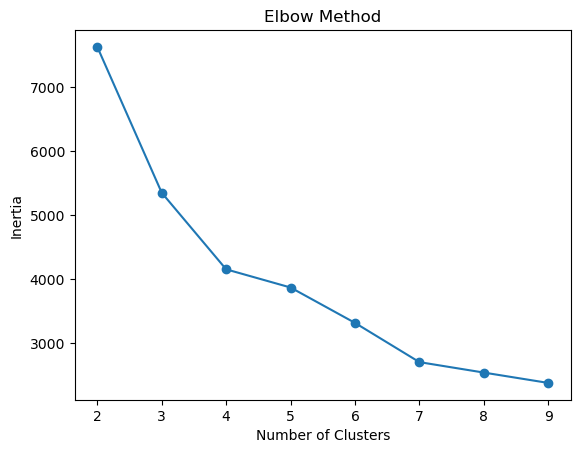

In [299]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Find the optimal number of clusters (Elbow Method)
inertia = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(flooring_encoded)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Use the chosen number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df['flooring_cluster'] = kmeans.fit_predict(flooring_encoded)

In [300]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(flooring_encoded, df['flooring_cluster'])
print("Silhouette Score for 5 clusters:", silhouette_avg)

Silhouette Score for 5 clusters: 0.7039405148034295


In [301]:
df['flooring_cluster'].value_counts()

flooring_cluster
3    4547
1    4446
2    2010
0     463
4     428
Name: count, dtype: int64

`observation`
- silhouette score is above 0.5, means clustering is generally well-formed. If it's lower (e.g., below 0.3), we might reconsider the number of clusters and 0.4 to 0.5: Moderate clustering performance — some overlap between clusters likely exists, but the separation isn't completely poor.
- silhouette score = 0.71 for 5 clusters shown that clustering is generally well-formed
- The number of missing values was 4454, and cluster 0 also contains 4454 values. This indicates that cluster 0 includes unknown values only
- Do not replace the values in cluster 0 with 'None' again.

In [302]:
df[['flooring','flooring_cluster']].head()

,flooring,flooring_cluster
0,vitrified,3
1,"vitrified, wooden, ceramic tiles",0
2,unknown,1
3,vitrified,3
4,vitrified,3


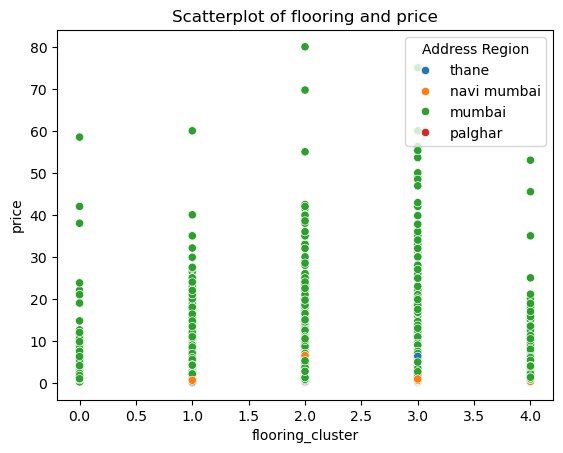

In [303]:
# Filter data for 'mumbai'
#filtered_df = df[df['addressregion'] == 'thane']

sns.scatterplot(x=df['flooring_cluster'], y=df['price'], hue=df['addressregion'])

# Add labels and title
plt.xlabel('flooring_cluster')
plt.ylabel('price')
plt.title('Scatterplot of flooring and price')
plt.legend(title='Address Region')
plt.show()

### method 2: This is assign weightage technique that I have perform already in mg_feature_engineering.ipynb notebook

### method 3: actual weightage
this method I have to perform or not that I can decide while woking here  

`observation`  
features datatype is incorrect, data type should be 'object' for this features : amenities_cluster , flooring_cluster

In [ ]:
# change feature datatypes as object : amenities_cluster , flooring_cluster
df['flooring_cluster'] = df['flooring_cluster'].astype(str)
df['amenities_cluster'] = df['amenities_cluster'].astype(str)

## furnish

### method 1 : OHE for furnish  

In [118]:
# Perform One-Hot Encoding
furnish_ohe = df['furnish'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, furnish_ohe], axis=1)

In [119]:
df[['furnish','unfurnished', 'semi-furnished', 'furnished']].sample(10)

,furnish,unfurnished,semi-furnished,furnished
4611,furnished,0,0,1
4439,furnished,0,0,1
10394,semi-furnished,0,1,0
9088,semi-furnished,0,1,0
6691,semi-furnished,0,1,0
9312,semi-furnished,0,1,0
126,unfurnished,1,0,0
8495,unfurnished,1,0,0
3773,unfurnished,1,0,0
10626,furnished,0,0,1


## property_type

### method 1 : OHE for property_type

In [131]:
# Perform One-Hot Encoding
furnish_ohe = df['property_type'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, furnish_ohe], axis=1)

In [132]:
df[['property_type','resale','new property']].sample(10)

,property_type,resale,new property
548,resale,1,0
3151,resale,1,0
9811,resale,1,0
1832,new property,0,1
9557,resale,1,0
5579,new property,0,1
7357,resale,1,0
5040,resale,1,0
662,resale,1,0
6689,new property,0,1


## status

### method 1 : OHE for status

In [144]:
# Perform One-Hot Encoding
furnish_ohe = df['status'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, furnish_ohe], axis=1)

In [145]:
df[['status', "under construction", "ready to move", "ongoing"]].sample(10)

,status,under construction,ready to move,ongoing
9555,ready to move,0,1,0
7105,ready to move,0,1,0
8543,ready to move,0,1,0
9006,ready to move,0,1,0
4111,ready to move,0,1,0
6557,ready to move,0,1,0
9571,ready to move,0,1,0
11596,under construction,1,0,0
7717,ready to move,0,1,0
4855,ready to move,0,1,0


## facing

### method 1 : OHE for facing

In [156]:
# Perform One-Hot Encoding
furnish_ohe = df['facing'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, furnish_ohe], axis=1)

In [157]:
df[['facing','east', 'north - east', 'west', 'north', 'north - west', 'south -west','south - east', 'south']].sample(10)

,facing,east,north - east,west,north,north - west,south -west,south - east,south
9853,north,0,0,0,1,0,0,0,0
9570,south - east,0,0,0,0,0,0,1,0
7826,west,0,0,1,0,0,0,0,0
1038,NaN,0,0,0,0,0,0,0,0
7292,east,1,0,0,0,0,0,0,0
7072,west,0,0,1,0,0,0,0,0
5788,east,1,0,0,0,0,0,0,0
2477,north - east,0,1,0,0,0,0,0,0
7327,east,1,0,0,0,0,0,0,0
3313,east,1,0,0,0,0,0,0,0


## seller

### method 1 : OHE for seller

In [169]:
# Perform One-Hot Encoding
furnish_ohe = df['seller'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, furnish_ohe], axis=1)

In [170]:
df[['seller','realestateagent', 'person', 'organization']].sample(10)

,seller,realestateagent,person,organization
5039,realestateagent,1,0,0
8221,realestateagent,1,0,0
4476,realestateagent,1,0,0
2539,realestateagent,1,0,0
10093,person,0,1,0
3383,realestateagent,1,0,0
2795,realestateagent,1,0,0
5145,realestateagent,1,0,0
1580,realestateagent,1,0,0
10984,realestateagent,1,0,0


## ownership

### method 1 : OHE for ownership

In [102]:
df['ownership'] = df['ownership'].fillna('unknown')

In [103]:
# Perform One-Hot Encoding
ownership_ohe = df['ownership'].str.get_dummies()

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, ownership_ohe], axis=1)

In [104]:
df[['ownership','leasehold', 'freehold', 'power of attorney', "co-operative society"]].sample(10)

,ownership,leasehold,freehold,power of attorney,co-operative society
2280,unknown,0,0,0,0
4760,unknown,0,0,0,0
9429,freehold,0,1,0,0
11897,unknown,0,0,0,0
1812,unknown,0,0,0,0
6305,co-operative society,0,0,0,1
3811,freehold,0,1,0,0
2504,freehold,0,1,0,0
1606,unknown,0,0,0,0
11501,co-operative society,0,0,0,1


## overlooking

### method 1 : OHE for overlooking

In [60]:
# Perform One-Hot Encoding
overlooking_ohe = df['overlooking'].str.get_dummies(sep=', ')

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, overlooking_ohe], axis=1)

In [61]:
df[['overlooking','main road', 'garden/park', 'pool']].sample(10)

,overlooking,main road,garden/park,pool
6555,garden/park,0,1,0
5211,main road,1,0,0
7575,main road,1,0,0
9543,garden/park,0,1,0
727,unknown,0,0,0
8703,main road,1,0,0
6712,"garden/park, main road, pool",1,1,1
6516,unknown,0,0,0
8729,garden/park,0,1,0
2852,main road,1,0,0


### method 2: assign weightage 
this method I have already performed in the feature_engineering.ipynb notebook

### method 3: actual weighatage for overlooking column 

note : use this method only after this structure 
so before using below code make sure that this steps are compulsory you have to do then use below code 

1. Handle Missing Values (e.g., SimpleImputer, KNNImputer, or domain-specific methods)
2. Apply Train-CV-Test Split then Compute Weightage for Overlooking (using the training set) then Use Weightage in CV and Test Sets (for this code is below)
3. Proceed with Model Training & Evaluation

I've structured the code like this
1. **Train-test split per `addressregion`**.
2. **Group the train data by `addressregion`**.
3. **Calculate weightages per region based on the training data**.
4. **Apply these weightages to both the train and test sets**.

In [62]:
df['overlooking'].value_counts()

overlooking
unknown                         3969
main road                       2242
garden/park, main road          1790
garden/park, main road, pool    1749
garden/park                     1536
garden/park, pool                451
pool                             102
main road, pool                   59
Name: count, dtype: int64

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to check if a property has a view
def has_overlooking_view(view):
    return view != 'unknown' and view != 'none of these'

# Sample data (assuming df is already loaded)
df['has_overlooking_view'] = df['overlooking'].apply(has_overlooking_view)

# Split data by address region
regions = ['mumbai', 'navi mumbai', 'thane', 'palghar']
region_dfs = {region: df[df['addressregion'] == region] for region in regions}

# Function to calculate weightages per region
def calculate_region_weightages(region_df):
    avg_price_with_overlook = region_df[region_df['has_overlooking_view']]['price'].mean()
    avg_price_without_overlook = region_df[~region_df['has_overlooking_view']]['price'].mean()
    
    # Analyze impact of each overlooking view type
    region_expanded = region_df.copy()
    region_expanded = region_expanded.assign(overlooking=region_expanded.overlooking.str.split(', ')).explode('overlooking')
    
    impact = region_expanded.groupby('overlooking')['price'].mean() - avg_price_without_overlook
    percentage_impact = (impact / avg_price_without_overlook) * 100
    
    def assign_weightage(percentage):
        return round(max(0, (percentage / percentage_impact.max()) * 10), 1)  # Normalize to 10
    
    # Train-test split
    train_df, test_df = train_test_split(region_df, test_size=0.2, random_state=42)
    
    # Train weightages
    train_expanded = train_df.copy()
    train_expanded = train_expanded.assign(overlooking=train_expanded.overlooking.str.split(', ')).explode('overlooking')
    
    impact_train = train_expanded.groupby('overlooking')['price'].mean() - avg_price_without_overlook
    percentage_impact_train = (impact_train / avg_price_without_overlook) * 100
    weightage_train = percentage_impact_train.apply(assign_weightage)
    
    # Function to calculate combined weightage
    def calculate_combined_weightage(overlooking, weightage_train):
        return sum(weightage_train.get(look, 0) for look in overlooking.split(', ') if look not in ['unknown', 'none of these'])
    
    # Apply weightage to train and test data
    train_df['weightage'] = train_df['overlooking'].apply(lambda x: calculate_combined_weightage(x, weightage_train))
    test_df['weightage'] = test_df['overlooking'].apply(lambda x: calculate_combined_weightage(x, weightage_train))
    
    return avg_price_with_overlook, avg_price_without_overlook, weightage_train, train_df, test_df

# Process each region
results = {region: calculate_region_weightages(region_dfs[region]) for region in regions}

# Display results
for region, (avg_price_with_overlook, avg_price_without_overlook, weightage_train, train_df, test_df) in results.items():
    print(f"Region: {region}")
    print("Average price with overlooking view:", avg_price_with_overlook)
    print("Average price without overlooking view:", avg_price_without_overlook)
    print("Weightage per overlooking view type (train data):")
    print(weightage_train)
    print("Train data with corrected weightages:")
    print(train_df[['overlooking', 'weightage']].head())
    print("Test data with corrected weightages:")
    print(test_df[['overlooking', 'weightage']].head())

Region: mumbai
Average price with overlooking view: 3.840548600508906
Average price without overlooking view: 2.8940727065093266
Weightage per overlooking view type (train data):
overlooking
garden/park     5.5
main road       3.6
pool           10.1
unknown         0.0
Name: price, dtype: float64
Train data with corrected weightages:
                 overlooking  weightage
699                  unknown        0.0
6533               main road        3.6
981                  unknown        0.0
9301  garden/park, main road        9.1
3222             garden/park        5.5
Test data with corrected weightages:
       overlooking  weightage
10284      unknown        0.0
10238      unknown        0.0
3548   garden/park        5.5
1541       unknown        0.0
1096       unknown        0.0
Region: navi mumbai
Average price with overlooking view: 1.3937418335089569
Average price without overlooking view: 1.070663594470046
Weightage per overlooking view type (train data):
overlooking
garden/par

`observation`  
- Performed 2 different methods to convert the extra_rooms column into numerical form:  
  - Method 1 : Actual weightage  
  - Method 2 : One-Hot Encoding (OHE)    
- Evaluate which method gives the best model performance and keep that as the final approach.

## extra_rooms 

### method 1 : OHE for extra_rooms 

In [89]:
# Perform One-Hot Encoding
extra_rooms_ohe = df['extra_rooms'].str.get_dummies(sep=', ')

# Concatenate OHE result with the original DataFrame
df = pd.concat([df, extra_rooms_ohe], axis=1)

In [90]:
df[['extra_rooms','study', 'servant', 'puja','store']].sample(10)

,extra_rooms,study,servant,puja,store
1706,unknown,0,0,0,0
5240,"servant, study",1,1,0,0
2665,none of these,0,0,0,0
514,unknown,0,0,0,0
6069,none of these,0,0,0,0
11215,unknown,0,0,0,0
10234,unknown,0,0,0,0
571,unknown,0,0,0,0
9438,unknown,0,0,0,0
2909,none of these,0,0,0,0


# EDA for above created features 

## amenities_cluster

In [171]:
# no of unique categories and value_counts
analyze_value_counts(df, 'amenities_cluster', top_n=5)  

KeyError: 'amenities_cluster'

In [ ]:
# missing values
df['amenities_cluster'].isna().sum()

In [ ]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'amenities_cluster', bar_top_n=5, pie_top_n=5)

In [ ]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'amenities_cluster',5, 0.90)

`observation`
- The flooring cluster indicates the types of amenities for the flat. The types of amenities include: 3 tier security system', 'ac in each room', 'activity deck4', 'aerobics room', 'aesthetically designed landscape garden', 'air conditioned','meditation area', 'mini cinema theatre' and many more.
- total 132 unique amenities we have.   
- A value of 1 (45.7%) means it can represent combination of several types from the list. For example, amenities_cluster = 1 could mean mix like ['meditation area', 'mini cinema theatre','event space & amphitheatre', 'fingerprint access', 'fire fighting equipment', 'fire sprinklers', 'fireplace', 'flower gardens']. The same applies to values 2 and 3, as the grouping was done during data cleaning.

## flooring_cluster

In [ ]:
# no of unique categories and value_counts
analyze_value_counts(df, 'flooring_cluster', top_n=5)  

In [ ]:
# missing values
df['flooring_cluster'].isna().sum()

In [ ]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'flooring_cluster', bar_top_n=5, pie_top_n=5)

In [ ]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'flooring_cluster',5, 0.90)

`observation`
- The flooring cluster indicates the types of flooring used in a room. The types of flooring include: ['ceramic tiles', 'granite', 'marble', 'marbonite', 'mosaic', 'normal tiles/kotah stone', 'unknown', 'vitrified', 'wooden'].   
- A value of 1 (38.60%) means it can represent either a single flooring type or a combination of several types from the list. For example, flooring_cluster = 1 could mean just 'ceramic tiles' or a mix like ['ceramic tiles', 'granite']. The same applies to values 2 and 3, as the grouping was done during data cleaning.